https://towardsdatascience.com/evaluation-metrics-for-recommender-systems-df56c6611093

https://github.com/statisticianinstilettos/recmetrics/blob/master/example.ipynb

# Imports

In [0]:
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
import scipy.sparse as sp
from sklearn.metrics import mean_squared_error
from math import sqrt
import itertools
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import random

def novelty(predicted, pop, u, n):
    """
    Computes the novelty for a list of recommendations
    Parameters
    ----------
    predicted : a list of lists
        Ordered predictions
        example: [['X', 'Y', 'Z'], ['X', 'Y', 'Z']]
    pop: dictionary
        A dictionary of all items alongside of its occurrences counter in the training data
        example: {1198: 893, 1270: 876, 593: 876, 2762: 867}
    u: integer
        The number of users in the training data
    n: integer
        The length of recommended lists per user
    Returns
    ----------
    novelty:
        The novelty of the recommendations in system level
    mean_self_information:
        The novelty of the recommendations in recommended top-N list level
    ----------    
    Metric Defintion:
    Zhou, T., Kuscsik, Z., Liu, J. G., Medo, M., Wakeling, J. R., & Zhang, Y. C. (2010).
    Solving the apparent diversity-accuracy dilemma of recommender systems.
    Proceedings of the National Academy of Sciences, 107(10), 4511-4515.
    """
    mean_self_information = []
    k = 0
    for sublist in predicted:
        self_information = 0
        k += 1
        for i in sublist:
            self_information += np.sum(-np.log2(pop[i]/u))
        mean_self_information.append(self_information/n)
    novelty = sum(mean_self_information)/k
    return novelty, mean_self_information

def prediction_coverage(predicted, catalog):
    """
    Computes the prediction coverage for a list of recommendations
    Parameters
    ----------
    predicted : a list of lists
        Ordered predictions
        example: [['X', 'Y', 'Z'], ['X', 'Y', 'Z']]
    catalog: list
        A list of all unique items in the training data
        example: ['A', 'B', 'C', 'X', 'Y', Z]
    Returns
    ----------
    prediction_coverage:
        The prediction coverage of the recommendations as a percent
        rounded to 2 decimal places
    ----------    
    Metric Defintion:
    Ge, M., Delgado-Battenfeld, C., & Jannach, D. (2010, September).
    Beyond accuracy: evaluating recommender systems by coverage and serendipity.
    In Proceedings of the fourth ACM conference on Recommender systems (pp. 257-260). ACM.
    """
    predicted_flattened = [p for sublist in predicted for p in sublist]
    unique_predictions = len(set(predicted_flattened))
    prediction_coverage = round(unique_predictions/(len(catalog)* 1.0)*100,2)
    return prediction_coverage

def catalog_coverage(predicted, catalog, k):
    """
    Computes the catalog coverage for k lists of recommendations
    Parameters
    ----------
    predicted : a list of lists
        Ordered predictions
        example: [['X', 'Y', 'Z'], ['X', 'Y', 'Z']]
    catalog: list
        A list of all unique items in the training data
        example: ['A', 'B', 'C', 'X', 'Y', Z]
    k: integer
        The number of observed recommendation lists
        which randomly choosed in our offline setup
    Returns
    ----------
    catalog_coverage:
        The catalog coverage of the recommendations as a percent
        rounded to 2 decimal places
    ----------    
    Metric Defintion:
    Ge, M., Delgado-Battenfeld, C., & Jannach, D. (2010, September).
    Beyond accuracy: evaluating recommender systems by coverage and serendipity.
    In Proceedings of the fourth ACM conference on Recommender systems (pp. 257-260). ACM.
    """
    sampling = random.choices(predicted, k=k)
    predicted_flattened = [p for sublist in sampling for p in sublist]
    L_predictions = len(set(predicted_flattened))
    catalog_coverage = round(L_predictions/(len(catalog)*1.0)*100,2)
    return catalog_coverage

def _ark(actual, predicted, k=10):
    """
    Computes the average recall at k.
    Parameters
    ----------
    actual : list
        A list of actual items to be predicted
    predicted : list
        An ordered list of predicted items
    k : int, default = 10
        Number of predictions to consider
    Returns:
    -------
    score : int
        The average recall at k.
    """
    if len(predicted)>k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0

    for i,p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)

    if not actual:
        return 0.0

    return score / len(actual)

def mark(actual, predicted, k=10):
    """
    Computes the mean average recall at k.
    Parameters
    ----------
    actual : a list of lists
        Actual items to be predicted
        example: [['A', 'B', 'X'], ['A', 'B', 'Y']]
    predicted : a list of lists
        Ordered predictions
        example: [['X', 'Y', 'Z'], ['X', 'Y', 'Z']]
    Returns:
    -------
        mark: int
            The mean average recall at k (mar@k)
    """
    return np.mean([_ark(a,p,k) for a,p in zip(actual, predicted)])

def personalization(predicted):
    """
    Personalization measures recommendation similarity across users.
    A high score indicates good personalization (user's lists of recommendations are different).
    A low score indicates poor personalization (user's lists of recommendations are very similar).
    A model is "personalizing" well if the set of recommendations for each user is different.
    Parameters:
    ----------
    predicted : a list of lists
        Ordered predictions
        example: [['X', 'Y', 'Z'], ['X', 'Y', 'Z']]
    Returns:
    -------
        The personalization score for all recommendations.
    """

    def make_rec_matrix(predicted):
        df = pd.DataFrame(data=predicted).reset_index().melt(
            id_vars='index', value_name='item',
        )
        df = df[['index', 'item']].pivot(index='index', columns='item', values='item')
        df = pd.notna(df)*1
        rec_matrix = sp.csr_matrix(df.values)
        return rec_matrix

    #create matrix for recommendations
    predicted = np.array(predicted)
    rec_matrix_sparse = make_rec_matrix(predicted)

    #calculate similarity for every user's recommendation list
    similarity = cosine_similarity(X=rec_matrix_sparse, dense_output=False)

    #get indicies for upper right triangle w/o diagonal
    upper_right = np.triu_indices(similarity.shape[0], k=1)

    #calculate average similarity
    personalization = np.mean(similarity[upper_right])
    return 1-personalization

def _single_list_similarity(predicted, feature_df, u):
    """
    Computes the intra-list similarity for a single list of recommendations.
    Parameters
    ----------
    predicted : a list
        Ordered predictions
        Example: ['X', 'Y', 'Z']
    feature_df: dataframe
        A dataframe with one hot encoded or latent features.
        The dataframe should be indexed by the id used in the recommendations.
    Returns:
    -------
    ils_single_user: float
        The intra-list similarity for a single list of recommendations.
    """
    # exception predicted list empty
    if not(predicted):
        raise Exception('Predicted list is empty, index: {0}'.format(u))

    #get features for all recommended items
    recs_content = feature_df.loc[predicted]
    recs_content = recs_content.dropna()
    recs_content = sp.csr_matrix(recs_content.values)

    #calculate similarity scores for all items in list
    similarity = cosine_similarity(X=recs_content, dense_output=False)

    #get indicies for upper right triangle w/o diagonal
    upper_right = np.triu_indices(similarity.shape[0], k=1)

    #calculate average similarity score of all recommended items in list
    ils_single_user = np.mean(similarity[upper_right])
    return ils_single_user

def intra_list_similarity(predicted, feature_df):
    """
    Computes the average intra-list similarity of all recommendations.
    This metric can be used to measure diversity of the list of recommended items.
    Parameters
    ----------
    predicted : a list of lists
        Ordered predictions
        Example: [['X', 'Y', 'Z'], ['X', 'Y', 'Z']]
    feature_df: dataframe
        A dataframe with one hot encoded or latent features.
        The dataframe should be indexed by the id used in the recommendations.
    Returns:
    -------
        The average intra-list similarity for recommendations.
    """
    feature_df = feature_df.fillna(0)
    Users = range(len(predicted))
    ils = [_single_list_similarity(predicted[u], feature_df, u) for u in Users]
    return np.mean(ils)

def mse(y, yhat):
    """
    Computes the mean square error (MSE)
    Parameters
    ----------
    yhat : Series or array. Reconstructed (predicted) ratings or interaction values.
    y: original true ratings or interaction values.
    Returns:
    -------
        The mean square error (MSE)
    """
    mse = mean_squared_error(y, yhat)
    return mse

def rmse(y, yhat):
    """
    Computes the root mean square error (RMSE)
    Parameters
    ----------
    yhat : Series or array. Reconstructed (predicted) ratings or values
    y: original true ratings or values.
    Returns:
    -------
        The mean square error (MSE)
    """
    rmse = sqrt(mean_squared_error(y, yhat))
    return rmse

def make_confusion_matrix(y, yhat):
    """
    Calculates and plots a confusion matrix
    Parameters
    ----------
    y : list or array of actual interaction values such as ratings
    yhat: list or array of actual predicted interaction values
    Returns:
    -------
        A confusion matrix plot
    """
    cm = confusion_matrix(y, yhat, labels=[1,0])
    cm = np.round(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis],4)*100

    fmt = ".2f"
    thresh = cm.max() / 2.
    descriptions = np.array([["True Positive", "False Negative"], ["False Positive", "True Negatives"]])
    colors = np.array([["green", "red"], ["red", "green"]])
    plt.imshow([[0,0],[0,0]], interpolation='nearest', cmap=plt.cm.Greys)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, format(cm[i, j], fmt)+'%\n' + descriptions[i, j],
                     horizontalalignment="center",
                     color=colors[i,j])
    plt.axhline(y=0.5, xmin=0, xmax=1, color="black", linewidth=0.75)
    plt.axvline(x=0.5, ymin=0, ymax=1, color="black", linewidth=0.75)
    plt.ylabel('True')
    plt.xlabel('Predicted')
    plt.title("Confusion Matrix")
    plt.xticks([0,1], [1,0], rotation=45)
    plt.yticks([0,1], [1,0])
    plt.show()


def recommender_precision(predicted, actual):
    """
    Computes the precision of each user's list of recommendations, and averages precision over all users.
    ----------
    actual : a list of lists
        Actual items to be predicted
        example: [['A', 'B', 'X'], ['A', 'B', 'Y']]
    predicted : a list of lists
        Ordered predictions
        example: [['X', 'Y', 'Z'], ['X', 'Y', 'Z']]
    Returns:
    -------
        precision: int
    """
    def calc_precision(predicted, actual):
        prec = [value for value in predicted if value in actual]
        prec = np.round(float(len(prec)) / float(len(predicted)), 4)
        return prec

    precision = np.mean(list(map(calc_precision, predicted, actual)))
    return precision


def recommender_recall(predicted, actual):
    """
    Computes the recall of each user's list of recommendations, and averages precision over all users.
    ----------
    actual : a list of lists
        Actual items to be predicted
        example: [['A', 'B', 'X'], ['A', 'B', 'Y']]
    predicted : a list of lists
        Ordered predictions
        example: [['X', 'Y', 'Z'], ['X', 'Y', 'Z']]
    Returns:
    -------
        recall: int
    """
    def calc_recall(predicted, actual):
        reca = [value for value in predicted if value in actual]
        reca = np.round(float(len(reca)) / float(len(actual)), 4)
        return reca

    recall = np.mean(list(map(calc_recall, predicted, actual)))
    return recall

In [2]:
!pip install surprise

     |████████████████████████████████| 6.5MB 3.2MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.0-cp36-cp36m-linux_x86_64.whl size=1673635 sha256=7dd5ff7d3654116dbbdf3962b73fc895b050f14e63119179f33e6b1b277d7a06
  Stored in directory: /root/.cache/pip/wheels/cc/fa/8c/16c93fccce688ae1bde7d979ff102f7bee980d9cfeb8641bcf
Successfully built scikit-surprise


In [0]:
import pandas as pd
import numpy as np
#import recmetrics
import matplotlib.pyplot as plt
from surprise import Reader, SVD, Dataset
from surprise.model_selection import train_test_split

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
import plotly.graph_objects as go
#from funcsigs import signature


def long_tail_plot(df, item_id_column, interaction_type, percentage=None, x_labels=True):
    """
    Plots the long tail for a user-item interaction dataset.
    ----------
    df: pandas dataframe
        user-item interaction dataframe
        example:
    item_id_column: str
        column name identifying the item ids in the dataframe
    interaction_type: str
        type of user-item interactions
        i.e. 'purchases', 'ratings' 'interactions', or 'clicks'
    percentage: float, default=None
        percent of volume to consider as the head (percent as a decimal)
        (if default=None no line will be plotted)
    x_tables bool, default=True
        if True, plot x-axis tick labels
        if False, no x-axis tick lavels will be plotted.
    Returns:
    -------
        A long tail plot
    """
    #calculate cumulative volumes
    volume_df = pd.DataFrame(df[item_id_column].value_counts())
    volume_df.reset_index(inplace=True)
    volume_df.columns = [item_id_column, "volume"]
    volume_df[item_id_column] = volume_df[item_id_column].astype(str)
    volume_df['cumulative_volume'] = volume_df['volume'].cumsum()
    volume_df['percent_of_total_volume'] = volume_df['cumulative_volume']/volume_df['volume'].sum()

    #line plot of cumulative volume
    x=range(0,len(volume_df))
    ax = sns.lineplot(x, y="volume", data=volume_df, color="black")
    plt.xticks(x)

    #set labels
    ax.set_title('Long Tail Plot')
    ax.set_ylabel('# of ' + interaction_type)
    ax.set_xlabel(item_id_column)

    if percentage != None:
        #plot vertical line at the tail location
        head = volume_df[volume_df.percent_of_total_volume <= percentage]
        tail = volume_df[volume_df.percent_of_total_volume > percentage]
        items_in_head = len(head)
        items_in_tail = len(tail)
        plt.axvline(x=items_in_head, color="red",  linestyle='--')

        # fill area under plot
        head = head.append(tail.head(1))
        x1 = head.index.values
        y1 = head['volume']
        x2 = tail.index.values
        y2 = tail['volume']
        ax.fill_between(x1, y1, color="blue", alpha=0.2)
        ax.fill_between(x2, y2,  color="orange", alpha=0.2)

        #create legend
        legend_elements = [Line2D([0], [0], marker='o', color='w', label=str(items_in_head)+': items in the head', markerfacecolor='blue', markersize=5),
                           Line2D([0], [0], marker='o', color='w', label=str(items_in_tail)+': items in the tail', markerfacecolor='orange', markersize=5)]
        ax.legend(handles=legend_elements, loc=1)

    else:
        x1 = volume_df[item_id_column]
        y1 = volume_df['volume']
        ax.fill_between(x1, y1, color="blue", alpha=0.3)
    if x_labels == False:
        plt.xticks([], [])
        ax.set(xticklabels=[])
    else:
        ax.set_xticklabels(labels = volume_df[item_id_column], rotation = 45, ha="right")

    plt.show()


def coverage_plot(coverage_scores, model_names):
    """
    Plots the coverage for a set of models to compare.
    ----------
    coverage_scores: list
        list of coverage scores in same order as model_names
        example: [0.17, 0.25, 0.76]
    model_names: list
        list of model names in same order as coverage_scores
        example: ['Model A', 'Model B', 'Model C']
    Returns:
    -------
        A coverage plot
    """
    #create palette
    recommender_palette = ["#ED2BFF", "#14E2C0", "#FF9F1C", "#5E2BFF","#FC5FA3"]
    sns.set_palette(recommender_palette)

    #make barplot
    ax = sns.barplot(x=model_names, y=coverage_scores)

    #set labels
    ax.set_title('Catalog Coverage in %')
    ax.set_ylabel('coverage')

    plt.show()

def personalization_plot(personalization_scores, model_names):
    """
    Plots the personalization for a set of models to compare.
    ----------
    personalization_scores: list
        list of personalization scores in same order as model_names
        example: [0.13, 0.52, 0.36]
    model_names: list
        list of model names in same order as coverage_scores
        example: ['Model A', 'Model B', 'Model C']
    Returns:
    -------
        A personalization plot
    """
    #create palette
    recommender_palette = ["#ED2BFF", "#14E2C0", "#FF9F1C", "#5E2BFF","#FC5FA3"]
    sns.set_palette(recommender_palette)

    #make barplot
    ax = sns.barplot(x=model_names, y=personalization_scores)

    #set labels
    ax.set_title("Personalization in %")
    ax.set_ylabel("personalization")

    plt.show()

def intra_list_similarity_plot(intra_list_similarity_scores, model_names):
    """
    Plots the intra-list similarity for a set of models to compare.
    ----------
    intra_list_similarity_scores: list
        list of intra-list similarity scores in same order as model_names
        example: [0.13, 0.52, 0.36]
    model_names: list
        list of model names in same order as coverage_scores
        example: ['Model A', 'Model B', 'Model C']
    Returns:
    -------
        A intra-list similarity plot
    """
    #create palette
    recommender_palette = ["#ED2BFF", "#14E2C0", "#FF9F1C", "#5E2BFF","#FC5FA3"]
    sns.set_palette(recommender_palette)

    #make barplot
    ax = sns.barplot(x=model_names, y=scores)

    #set labels
    ax.set_title("Similarity in %")
    ax.set_ylabel("similarity in %")

    plt.show()

def mark_plot(mark_scores, model_names, k_range):
    """
    Plots the mean average recall at k for a set of models to compare.
    ----------
    mark_scores: list of lists
        list of list of mar@k scores over k. This lis is in same order as model_names
        example: [[0.17, 0.25, 0.76],[0.2, 0.5, 0.74]]
    model_names: list
        list of model names in same order as coverage_scores
        example: ['Model A', 'Model B']
    k_range: list
        list or array indeitifying all k values in order
        example: [1,2,3,4,5,6,7,8,9,10]
    Returns:
    -------
        A mar@k plot
    """
    #create palette
    recommender_palette = ["#ED2BFF", "#14E2C0", "#FF9F1C", "#5E2BFF","#FC5FA3"]
    sns.set_palette(recommender_palette)

    #lineplot
    mark_df = pd.DataFrame(np.column_stack(mark_scores), k_range, columns=model_names)
    ax = sns.lineplot(data=mark_df)
    plt.xticks(k_range)
    plt.setp(ax.lines,linewidth=5)

    #set labels
    ax.set_title('Mean Average Recall at K (MAR@K) Comparison')
    ax.set_ylabel('MAR@K')
    ax.set_xlabel('K')

    plt.show()


def mapk_plot(mapk_scores, model_names, k_range):
    """
    Plots the mean average precision at k for a set of models to compare.
    ----------
    mapk_scores: list of lists
        list of list of map@k scores over k. This lis is in same order as model_names
        example: [[0.17, 0.25, 0.76],[0.2, 0.5, 0.74]]
    model_names: list
        list of model names in same order as coverage_scores
        example: ['Model A', 'Model B']
    k_range: list
        list or array indeitifying all k values in order
        example: [1,2,3,4,5,6,7,8,9,10]
    Returns:
    -------
        A map@k plot
    """
    #create palette
    recommender_palette = ["#ED2BFF", "#14E2C0", "#FF9F1C", "#5E2BFF","#FC5FA3"]
    sns.set_palette(recommender_palette)

    #lineplot
    mapk_df = pd.DataFrame(np.column_stack(mapk_scores), k_range, columns=model_names)
    ax = sns.lineplot(data=mapk_df)
    plt.xticks(k_range)
    plt.setp(ax.lines,linewidth=5)

    #set labels
    ax.set_title('Mean Average Precision at K (MAP@K) Comparison')
    ax.set_ylabel('MAP@K')
    ax.set_xlabel('K')
    plt.show()



def class_separation_plot(pred_df, n_bins=150, threshold=None, figsize=(10,6), title=None):
    """
    Plots the predicted class probabilities for multiple classes.
    Usefull for visualizing predicted interaction values such as 5 star ratings, where a "class" is a star rating,
    or visualizing predicted class probabilities for binary classification model or recommender system.
    The true class states are colored.
    ----------
    pred_df: pandas dataframe
        a dataframe containing a column of predicted interaction values or classification probabilites,
        and a column of true class 1 and class 0 states.
        This dataframe must contain columns named "predicted" and "truth"
        example:
        	predicted | truth
        	5.345345	|  5
        	2.072020	|  2
    n_bins: number of bins for histogram.
    threshold: float. default = 0.5
        A single number between 0 and 1 identifying the threshold to classify observations to class
        example: 0.5
    figsize: size of figure
    title: plot title
    Returns:
    -------
        A classification probability plot
    """
    recommender_palette = ["#ED2BFF", "#14E2C0", "#FF9F1C", "#5E2BFF", "#FC5FA3"]
    classes = pred_df.truth.unique()
    plt.figure(figsize=figsize)
    for i in range(len(classes)):
        single_class = classes[i]
        sns.distplot( pred_df.query("truth == @single_class")["predicted"] , bins=n_bins, color=recommender_palette[i], label="True {}".format(single_class))
    plt.legend()
    if threshold == None: pass
    else: plt.axvline(threshold, color="black", linestyle='--')
    plt.xlabel("Predicted value")
    plt.ylabel("Frequency")
    if title == None: plt.title(" ")
    else: plt.title(title)
    plt.show()


def roc_plot(actual, model_probs, model_names, figsize=(10,10)):
    """
    Receiver Operating Characteristic Plot. Can plot multiple models.
    ----------
    actual: array of dataframe of true classes assignements.
        example:
        [1,1,0,1,0]
    model_probs: list of arrays
        a list containing classification probabilites for each model in order.
        example:
        model_probs = [class_probs_1, class_probs_2]
    model_names: list of strings
        a list containing names for each model in order.
        example:
        model_names = ["GBT", "Logistic Regression"]
    figsize: size of figure
    Returns:
    -------
        Receiver Operating Characteristic Plot with AUC in the legend.
    """
    model_names = make_listy(model_names)
    if not is_listy(model_probs): model_probs = [model_probs]

    if len(model_names) > 5:
        return ValueError("Can only compare 5 models or less.")

    colors = ["#ED2BFF", "#14E2C0", "#FF9F1C", "#5E2BFF","#FC5FA3"]
    fig,ax = plt.subplots(figsize=figsize)
    ax.plot([0, 1], [0, 1], 'r--')
    ax.set_title('Receiver Operating Characteristic Plot')
    ax.set_ylabel('True Positive Rate')
    ax.set_xlabel('False Positive Rate')

    for m in range(len(model_names)):
        fpr, tpr, threshold = roc_curve(actual, model_probs[m])
        roc_auc = auc(fpr, tpr)
        ax = sns.lineplot(x=fpr,
                          y=tpr,
                          lw=2,
                          color=colors[m],
                          label = model_names[m] + ' AUC = %0.4f' % roc_auc)
    plt.show()


def precision_recall_plot(targs, preds, figsize=(6,6)):
    """
    Plots the precision recall curve
    ----------
    targs: array-like true class labels
    preds: array-like predicted probabilities
    figsize: size of figure
    Returns:
    -------
        A precision and recall curve
    """
    average_precision = average_precision_score(targs, preds)
    precision, recall, _ = precision_recall_curve(targs, preds)
    plt.figure(figsize=figsize)
    step_kwargs = ({'step': 'post'}
                   if 'step' in signature(plt.fill_between).parameters
                   else {})
    plt.step(recall, precision, color='b', alpha=0.2,
             where='post')
    plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
        average_precision))
    plt.show()


def make_listy(p):
    if isinstance(p, str): return [p]
    try:
        _ = iter(p)
    except TypeError:
        p = [p]
    return p


def is_listy(x): return isinstance(x, (tuple,list))

def metrics_plot(model_names, coverage_scores, personalization_scores, intra_list_similarity_scores):

    """
    Plots the coverage, personalization and intra-list similarity for a set of models to compare.
    ----------
    model_names: list
        list of model names in same order as coverage_scores
        example: ['Model A', 'Model B', 'Model C']
    coverage_scores: list
        list of scores in same order as model_names
        example: [0.17, 0.25, 0.76]
    personalization_scores: list
        list of scores in same order as model_names
        example: [0.43, 0.23, 0.44]
    intra_list_similarity: list
        list of scores in same order as model_names
        example: [0.23, 0.21, 0.69]
    Returns:
    -------
        An interactive metrics plot
    """

    fig = go.Figure()

    for model_name, coverage, personalization, intra_list_similarity in zip(model_names, coverage_scores, personalization_scores, intra_list_similarity_scores):
        fig.add_trace(go.Scatterpolar(
              r=[coverage, personalization * 100, intra_list_similarity * 100],
              theta=['coverage','personalization','intra list similarity'],
              fill='tonext',
              name=model_name
        ))

    fig.update_layout(
      polar=dict(
        radialaxis=dict(
          visible=True,
          range=[0, 100]
        )),
      showlegend=True
    )

    fig.show()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# MovieLense Dataset
Using the MovieLens 20M Dataset dataset for examples. You can download this data here: https://grouplens.org/datasets/movielens/20m/

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [6]:
!ls "/content/drive/My Drive/ml-20m"

genome-scores.csv  links.csv   ratings.csv  tags.csv
genome-tags.csv    movies.csv  README.txt


In [0]:
ratings = pd.read_csv('/content/drive/My Drive/ml-20m/ratings.csv')
ratings = ratings.query('rating >=3')
ratings.reset_index(drop=True, inplace=True)

In [8]:
ratings.shape

(16486759, 4)

In [9]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580


In [0]:
#only consider ratings from users who have rated over n movies
n=1000
users = ratings.userId.value_counts()
users = users[users>n].index.tolist()

In [11]:
ratings = ratings.query('userId in @users')
print(ratings.shape)
ratings.head(3)

(1317902, 4)


,userId,movieId,rating,timestamp
15918,156,1,5.0,1037739266
15919,156,2,5.0,1040937649
15920,156,4,3.0,1038801803


In [12]:
# get movie features

rated_movies = ratings.movieId.tolist()
movies = pd.read_csv('/content/drive/My Drive/ml-20m/movies.csv')
movies = movies.query('movieId in @rated_movies')
movies.set_index("movieId", inplace=True, drop=True)

movies = movies.genres.str.split("|", expand=True)
movies.reset_index(inplace=True)
movies = pd.melt(movies, id_vars='movieId', value_vars=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

movies.drop_duplicates("movieId", inplace=True)
movies.set_index('movieId', inplace=True)

movies = pd.get_dummies(movies.value)
#movies = movies[['Action', 'Romance', 'Western', 'Comedy', 'Crime']]
movies.head()

,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movieId,,,,,,,,,,,,,,,,,,,,
1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Long Tail Plot Example

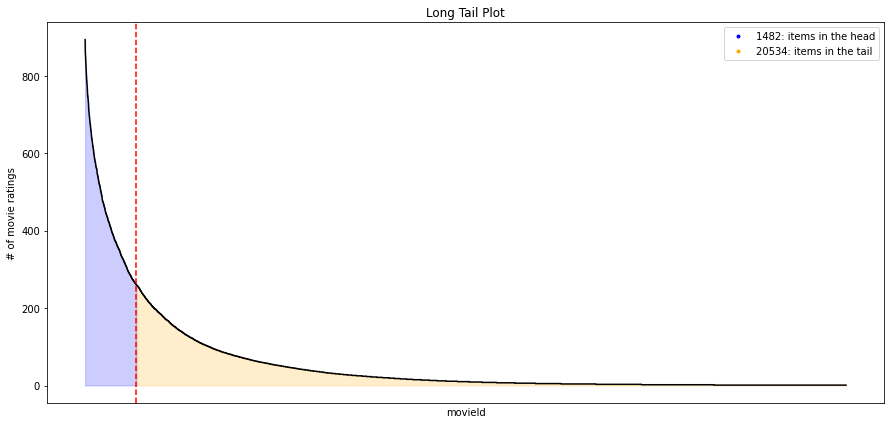

In [13]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15, 7))
long_tail_plot(df=ratings, 
             item_id_column="movieId", 
             interaction_type="movie ratings", 
             percentage=0.5,
             x_labels= False)

In [14]:
1482/(1482+20534)*100

6.731468023255814

# Collaborative Filter Recommender
Creating a simple CF to demonstrate recommender metrics in action. I've implemented collaborative filtering using a SVD approach in the surprise package. The surprise package also takes care of the test train split. The collaborative filter transforms user-item interactions into latent space, and reconstructs the user-item matrix to impute ratings missing movie ratings. The predicted rating is the dot product between the user and movie vectors in latent space. 

In [0]:
#format data for surprise
reader = Reader(rating_scale=(0, 5))

data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)
trainset, testset = train_test_split(data, test_size=0.25)

In [16]:
#train SVD recommender 
algo = SVD()
algo.fit(trainset)

In [17]:
#make predictions on test set. 
test = algo.test(testset)
test = pd.DataFrame(test)
test.drop("details", inplace=True, axis=1)
test.columns = ['userId', 'movieId', 'actual', 'cf_predictions']
test.head()

,userId,movieId,actual,cf_predictions
0,77696,1459,3.0,3.440327
1,127501,91323,3.0,3.157880
2,93387,40959,4.0,3.496253
3,122436,2941,4.0,3.724514
4,43180,832,4.0,3.665817


In [18]:
#evaluate model with MSE and RMSE
print(mse(test.actual, test.cf_predictions))
print(rmse(test.actual, test.cf_predictions))

0.26534858864700067
0.515119975002912


In [0]:
#create model (matrix of predicted values)
cf_model = test.pivot_table(index='userId', columns='movieId', values='cf_predictions').fillna(0)

In [20]:
cf_model.head()

movieId,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,34,35,36,38,39,40,41,42,...,129307,129309,129335,129354,129360,129397,129425,129428,129451,129460,129506,129555,129659,129707,129749,129937,129951,130073,130075,130328,130622,130628,130804,130840,131050,131090,131096,131098,131104,131106,131118,131122,131126,131136,131138,131174,131176,131239,131243,131248
userId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
156,0.000000,3.892954,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.456258,0.0,0.000000,0.0,0.0,4.024474,0.0,0.000000,0.0,3.830215,0.000000,3.606659,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,3.718659,0.0,0.0,0.0,0.0,0.0,3.518849,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,3.767262,0.0,0.0,3.984142,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.024563,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
359,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,3.443546,0.0,0.000000,3.611722,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.210736,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
394,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
572,4.239284,3.710390,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.043180,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
test.shape

(329476, 4)

In [22]:
test.head()

,userId,movieId,actual,cf_predictions
0,77696,1459,3.0,3.440327
1,127501,91323,3.0,3.157880
2,93387,40959,4.0,3.496253
3,122436,2941,4.0,3.724514
4,43180,832,4.0,3.665817


In [0]:
test['err'] = np.abs(test['cf_predictions'] - test['actual']) / test['actual']

In [24]:
test.head()

,userId,movieId,actual,cf_predictions,err
0,77696,1459,3.0,3.440327,0.146776
1,127501,91323,3.0,3.157880,0.052627
2,93387,40959,4.0,3.496253,0.125937
3,122436,2941,4.0,3.724514,0.068871
4,43180,832,4.0,3.665817,0.083546


In [25]:
test['err'].agg(['mean','median'])

mean      0.112511
median    0.095363
Name: err, dtype: float64

In [0]:
def get_users_predictions(user_id, n, model):
    recommended_items = pd.DataFrame(model.loc[user_id])
    recommended_items.columns = ["predicted_rating"]
    recommended_items = recommended_items.sort_values('predicted_rating', ascending=False)    
    recommended_items = recommended_items.head(n)
    return recommended_items.index.tolist()

In [27]:
#get example prediction
get_users_predictions(156, 10, cf_model)

[2762, 589, 1234, 1210, 47, 590, 1246, 1610, 1954, 1307]

In [0]:
#format test data
test = test.copy().groupby('userId')['movieId'].agg((lambda x: list(set(x))))

In [0]:
test = test.to_frame()

In [0]:
test = test.rename({'movieId':'actual'},axis=1)

In [31]:
test.head()

,actual
userId,
156,"[2049, 2, 2054, 2057, 2058, 12, 2062, 17, 21, ..."
208,"[3079, 1223, 523, 2571, 524, 14, 2575, 3598, 1..."
359,"[6659, 2565, 7173, 45062, 69640, 6664, 1546, 1..."
394,"[1027, 1019, 3083, 1042, 2066, 4116, 5146, 464..."
572,"[1, 33794, 514, 516, 5125, 39427, 2053, 2, 547..."


In [32]:
#make recommendations for all members in the test data
cf_recs = [] = []
for user in test.index:
    cf_predictions = get_users_predictions(user, 10, cf_model)
    cf_recs.append(cf_predictions)
        
test['cf_predictions'] = cf_recs
test.head()

,actual,cf_predictions
userId,,
156,"[2049, 2, 2054, 2057, 2058, 12, 2062, 17, 21, ...","[2762, 589, 1234, 1210, 47, 590, 1246, 1610, 1..."
208,"[3079, 1223, 523, 2571, 524, 14, 2575, 3598, 1...","[1252, 750, 2019, 593, 318, 5291, 898, 6016, 1..."
359,"[6659, 2565, 7173, 45062, 69640, 6664, 1546, 1...","[527, 1197, 44555, 47, 4973, 1201, 32657, 293,..."
394,"[1027, 1019, 3083, 1042, 2066, 4116, 5146, 464...","[750, 924, 296, 922, 2997, 3134, 2019, 3683, 5..."
572,"[1, 33794, 514, 516, 5125, 39427, 2053, 2, 547...","[318, 2028, 1198, 5952, 33794, 4995, 6539, 1, ..."


# Popularity Recommender
Creating a simple popularity recommender to demonstrate recommender metrics in action. The popularity recommender simply recommends the top 10 movies to every user.

In [33]:
#make recommendations for all members in the test data
popularity_recs = ratings.movieId.value_counts().head(10).index.tolist()

pop_recs = []
for user in test.index:
    pop_predictions = popularity_recs
    pop_recs.append(pop_predictions)
        
test['pop_predictions'] = pop_recs
test.head()

,actual,cf_predictions,pop_predictions
userId,,,
156,"[2049, 2, 2054, 2057, 2058, 12, 2062, 17, 21, ...","[2762, 589, 1234, 1210, 47, 590, 1246, 1610, 1...","[1198, 1270, 593, 2762, 318, 2571, 260, 1240, ..."
208,"[3079, 1223, 523, 2571, 524, 14, 2575, 3598, 1...","[1252, 750, 2019, 593, 318, 5291, 898, 6016, 1...","[1198, 1270, 593, 2762, 318, 2571, 260, 1240, ..."
359,"[6659, 2565, 7173, 45062, 69640, 6664, 1546, 1...","[527, 1197, 44555, 47, 4973, 1201, 32657, 293,...","[1198, 1270, 593, 2762, 318, 2571, 260, 1240, ..."
394,"[1027, 1019, 3083, 1042, 2066, 4116, 5146, 464...","[750, 924, 296, 922, 2997, 3134, 2019, 3683, 5...","[1198, 1270, 593, 2762, 318, 2571, 260, 1240, ..."
572,"[1, 33794, 514, 516, 5125, 39427, 2053, 2, 547...","[318, 2028, 1198, 5952, 33794, 4995, 6539, 1, ...","[1198, 1270, 593, 2762, 318, 2571, 260, 1240, ..."


# Random Recommender
Creating a simple random recommender to demonstrate recommender metrics in action. The random recommender simply recommends 10 random movies to every user.

In [34]:
#make recommendations for all members in the test data

ran_recs = []
for user in test.index:
    random_predictions = ratings.movieId.sample(10).values.tolist()
    ran_recs.append(random_predictions)
        
test['random_predictions'] = ran_recs
test.head()

,actual,cf_predictions,pop_predictions,random_predictions
userId,,,,
156,"[2049, 2, 2054, 2057, 2058, 12, 2062, 17, 21, ...","[2762, 589, 1234, 1210, 47, 590, 1246, 1610, 1...","[1198, 1270, 593, 2762, 318, 2571, 260, 1240, ...","[1556, 2313, 697, 3251, 5139, 4447, 541, 2124,..."
208,"[3079, 1223, 523, 2571, 524, 14, 2575, 3598, 1...","[1252, 750, 2019, 593, 318, 5291, 898, 6016, 1...","[1198, 1270, 593, 2762, 318, 2571, 260, 1240, ...","[3426, 2617, 4398, 1299, 2527, 4526, 45447, 79..."
359,"[6659, 2565, 7173, 45062, 69640, 6664, 1546, 1...","[527, 1197, 44555, 47, 4973, 1201, 32657, 293,...","[1198, 1270, 593, 2762, 318, 2571, 260, 1240, ...","[54999, 3504, 74275, 115210, 64614, 593, 4709,..."
394,"[1027, 1019, 3083, 1042, 2066, 4116, 5146, 464...","[750, 924, 296, 922, 2997, 3134, 2019, 3683, 5...","[1198, 1270, 593, 2762, 318, 2571, 260, 1240, ...","[3211, 6755, 1256, 4849, 5812, 66304, 1441, 29..."
572,"[1, 33794, 514, 516, 5125, 39427, 2053, 2, 547...","[318, 2028, 1198, 5952, 33794, 4995, 6539, 1, ...","[1198, 1270, 593, 2762, 318, 2571, 260, 1240, ...","[1225, 222, 5294, 1025, 223, 1962, 31658, 2469..."


# Recall

In [0]:
actual = test.actual.values.tolist()
cf_predictions = test.cf_predictions.values.tolist()
pop_predictions = test.pop_predictions.values.tolist()
random_predictions = test.random_predictions.values.tolist()

In [36]:
pop_mark = []
for K in np.arange(1, 11):
    pop_mark.extend([mark(actual, pop_predictions, k=K)])
pop_mark

[0.0007683814848591266,
 0.0012844042129366586,
 0.001607228219028817,
 0.00194071517778944,
 0.0022078706775896595,
 0.0024449030204220967,
 0.0026859764106708403,
 0.002933539201284406,
 0.0031680683891334646,
 0.003375166825293208]

In [37]:
random_mark = []
for K in np.arange(1, 11):
    random_mark.extend([mark(actual, random_predictions, k=K)])
random_mark

[0.0002081439138226562,
 0.0003400735402315136,
 0.000471844348699864,
 0.0005535359137981397,
 0.0006358190215251799,
 0.0006950757902322833,
 0.0007467420781107198,
 0.0007942108577949421,
 0.0008361629770374505,
 0.0008740654792554899]

In [38]:
cf_mark = []
for K in np.arange(1, 11):
    cf_mark.extend([mark(actual, cf_predictions, k=K)])
cf_mark

[0.0030812620578780114,
 0.006162524115756023,
 0.009243786173634035,
 0.012325048231512046,
 0.015406310289390058,
 0.01848757234726807,
 0.02156883440514608,
 0.02465009646302409,
 0.027731358520902104,
 0.030812620578780116]

# Mark Plot

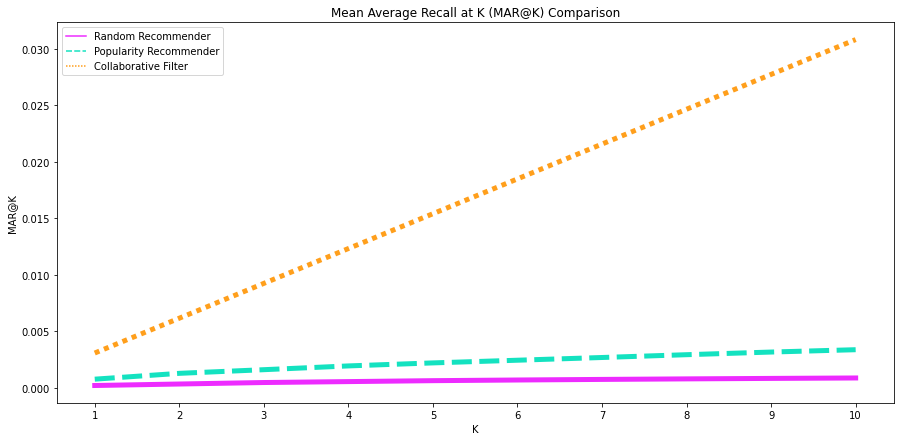

In [39]:
mark_scores = [random_mark, pop_mark, cf_mark]
index = range(1,10+1)
names = ['Random Recommender', 'Popularity Recommender', 'Collaborative Filter']

fig = plt.figure(figsize=(15, 7))
mark_plot(mark_scores, model_names=names, k_range=index)

# Presicion

In [0]:
import numpy as np

def apk(actual, predicted, k=10):
    """
    Computes the average precision at k.
    This function computes the average prescision at k between two lists of
    items.
    Parameters
    ----------
    actual : list
             A list of elements that are to be predicted (order doesn't matter)
    predicted : list
                A list of predicted elements (order does matter)
    k : int, optional
        The maximum number of predicted elements
    Returns
    -------
    score : double
            The average precision at k over the input lists
    """
    if len(predicted)>k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0

    for i,p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)

    if not actual:
        return 0.0

    return score / min(len(actual), k)

def mapk(actual, predicted, k=10):
    """
    Computes the mean average precision at k.
    This function computes the mean average prescision at k between two lists
    of lists of items.
    Parameters
    ----------
    actual : list
             A list of lists of elements that are to be predicted 
             (order doesn't matter in the lists)
    predicted : list
                A list of lists of predicted elements
                (order matters in the lists)
    k : int, optional
        The maximum number of predicted elements
    Returns
    -------
    score : double
            The mean average precision at k over the input lists
    """
    return np.mean([apk(a,p,k) for a,p in zip(actual, predicted)])

In [41]:
pop_mapk = []
for K in np.arange(1, 11):
    pop_mapk.extend([mapk(actual, pop_predictions, k=K)])
pop_mapk

[0.2497320471596999,
 0.20846730975348338,
 0.17470525187566988,
 0.15802518756698822,
 0.14391211146838156,
 0.13311599380731212,
 0.12547374791288435,
 0.12000523146021538,
 0.11499439520161206,
 0.11038670273396961]

In [42]:
random_mapk = []
for K in np.arange(1, 11):
    random_mapk.extend([mapk(actual, random_predictions, k=K)])
random_mapk

[0.07181136120042872,
 0.05841371918542337,
 0.05347147790877694,
 0.04720435869953554,
 0.04346552340121472,
 0.03964511134929141,
 0.03640950485231606,
 0.03390145715306487,
 0.03173572950278916,
 0.029912638867622788]

In [43]:
cf_mapk = []
for K in np.arange(1, 11):
    cf_mapk.extend([mapk(actual, cf_predictions, k=K)])
cf_mapk

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

In [44]:
mapk(actual, cf_predictions, k=K)

1.0

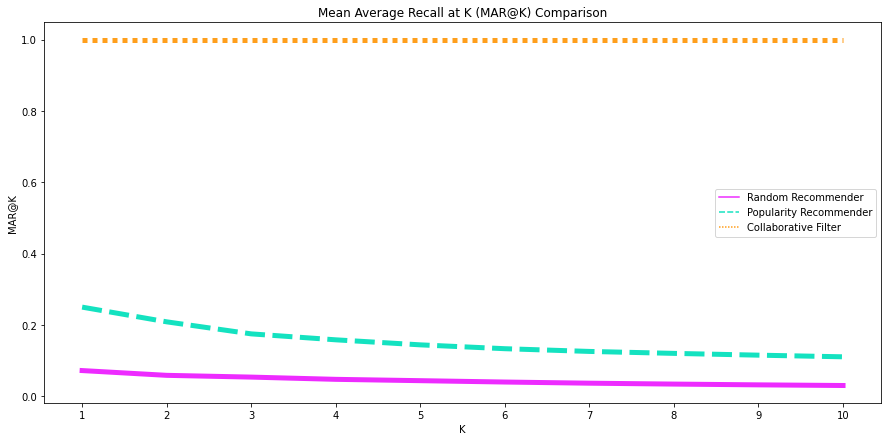

In [45]:
mark_scores = [random_mapk, pop_mapk, cf_mapk]
index = range(1,10+1)
names = ['Random Recommender', 'Popularity Recommender', 'Collaborative Filter']

fig = plt.figure(figsize=(15, 7))
mark_plot(mark_scores, model_names=names, k_range=index)

# Prediction Coverage

In [0]:
catalog = ratings.movieId.unique().tolist()
random_coverage = prediction_coverage(ran_recs, catalog)
pop_coverage = prediction_coverage(pop_recs, catalog)
cf_coverage = prediction_coverage(cf_recs, catalog)

# Catalog Coverage

In [0]:
# N=100 observed recommendation lists
random_cat_coverage = catalog_coverage(ran_recs, catalog, 100)
pop_cat_coverage = catalog_coverage(pop_recs, catalog, 100)
cf_cat_coverage = catalog_coverage(cf_recs, catalog, 100)

# Coverage Plot

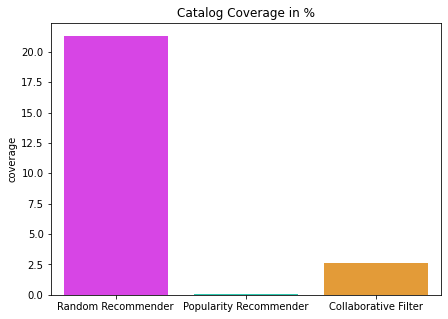

In [48]:
# plot of prediction coverage
coverage_scores = [random_coverage, pop_coverage, cf_coverage]
model_names = ['Random Recommender', 'Popularity Recommender', 'Collaborative Filter']

fig = plt.figure(figsize=(7, 5))
coverage_plot(coverage_scores, model_names)

# Novelty

In [0]:
nov = ratings.movieId.value_counts()
pop = dict(nov)

In [0]:
random_novelty,random_mselfinfo_list = novelty(ran_recs, pop, len(users), 10)
pop_novelty,pop_mselfinfo_list = novelty(pop_recs, pop, len(users), 10)
cf_novelty,cf_mselfinfo_list = novelty(cf_recs, pop, len(users), 10)

In [51]:
print(random_novelty, pop_novelty, cf_novelty)

2.2666800601455375 0.10697151566593387 0.696294720017528


# similarity matrix

In [52]:
algo.qi.shape

(20877, 100)

In [53]:
algo.qi

array([[ 0.11927651,  0.00852996, -0.00047733, ...,  0.04390569,
         0.02002183,  0.1061589 ],
       [-0.06132132,  0.06990097, -0.01115287, ..., -0.14468949,
         0.05021225,  0.03466077],
       [-0.01537662, -0.04181252,  0.12917538, ...,  0.01609578,
        -0.00704859,  0.09754471],
       ...,
       [-0.04671201,  0.00731126,  0.03452471, ...,  0.01886823,
        -0.04311528,  0.12101621],
       [-0.0411443 ,  0.04367818,  0.10738278, ..., -0.0681059 ,
         0.09549545,  0.08242006],
       [ 0.03921106, -0.06114844, -0.05070062, ..., -0.1264924 ,
         0.11736096, -0.13966406]])

In [0]:
df = pd.DataFrame(algo.qi)

In [55]:
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
0,0.119277,0.008530,-0.000477,0.118144,0.017376,0.158179,-0.108195,0.092784,0.002184,0.094579,0.087971,-0.020425,-0.146685,0.068616,-0.116838,-0.046089,-0.057576,0.043984,0.029387,0.014293,-0.112137,0.135814,-0.237534,0.064925,0.002861,0.016307,-0.082508,0.029127,-0.050318,-0.181724,-0.032935,-0.045027,-0.027959,0.008733,-0.069559,-0.055225,-0.045393,-0.048613,-0.170916,0.062094,...,0.017812,0.012499,0.204576,0.142423,0.119925,-0.063458,0.004112,-0.159284,-0.020317,0.079644,0.033277,-0.104044,-0.106196,0.054864,-0.026329,-0.054517,-0.075493,-0.011933,0.067486,-0.033221,-0.086234,0.154162,0.216945,0.032753,0.064823,0.021177,-0.102937,-0.086475,0.151572,-0.018518,0.025678,0.000625,0.093691,0.211636,0.099763,-0.025636,-0.062954,0.043906,0.020022,0.106159
1,-0.061321,0.069901,-0.011153,-0.053418,-0.100244,0.009763,0.019856,0.058409,-0.024088,-0.045107,0.040629,0.059836,0.188190,-0.019460,0.110092,0.129390,0.001057,0.032976,-0.084319,-0.011961,-0.011108,0.112279,-0.058595,-0.079407,-0.158675,-0.172336,-0.010679,0.073337,-0.004508,-0.004837,0.024237,0.061139,-0.069025,-0.005826,0.062799,0.007075,0.034384,-0.208617,-0.039793,-0.093626,...,-0.009528,-0.067247,-0.083783,0.115184,-0.032632,-0.096698,0.061552,0.016074,-0.036229,-0.002781,-0.119449,-0.055725,-0.073728,0.075492,-0.028980,0.012759,-0.034219,-0.141593,-0.033220,-0.096515,0.072971,-0.055068,-0.090688,-0.092150,-0.060576,0.108573,0.168420,0.058421,-0.074034,-0.014815,0.132619,0.017679,-0.103001,0.191316,-0.117091,0.058300,-0.044308,-0.144689,0.050212,0.034661
2,-0.015377,-0.041813,0.129175,0.075171,0.145751,0.063431,-0.031553,-0.028643,-0.117052,0.083893,0.096963,-0.098599,-0.049373,0.062601,-0.138976,-0.075296,0.007330,-0.080741,0.047305,-0.085033,-0.053122,-0.048722,-0.146736,0.065544,-0.103152,0.051368,0.006724,0.056619,-0.082589,-0.014084,0.073695,0.062472,0.008774,-0.094692,-0.068684,0.024603,0.018903,0.032106,-0.011509,-0.129685,...,-0.147392,-0.056947,0.005540,0.139918,0.024609,-0.075833,0.097134,0.014661,0.036361,-0.104503,0.203675,-0.069338,-0.124152,0.037425,-0.134286,0.029831,-0.230380,-0.042167,0.061356,-0.163265,0.006760,0.105409,0.163656,0.035436,0.083554,-0.038688,-0.014798,0.063063,0.093725,0.116971,0.030907,0.067390,0.097974,0.090363,0.023971,0.024890,-0.082282,0.016096,-0.007049,0.097545
3,-0.125809,0.085839,0.047557,-0.016383,-0.113651,-0.170651,-0.098332,0.062603,0.001294,0.110277,-0.041769,-0.098270,-0.041796,0.137570,0.021768,-0.126963,0.061907,-0.071789,-0.133432,-0.028383,-0.079997,0.032283,-0.062945,0.063735,0.043220,0.099325,-0.017498,0.037275,0.204471,-0.160403,-0.069791,-0.108166,-0.110153,0.220461,0.031100,-0.001907,-0.001543,0.032117,-0.034505,-0.020674,...,0.123881,-0.210975,0.104964,0.057872,0.097289,0.048356,0.021591,-0.123509,-0.151013,0.044858,-0.129759,0.007037,-0.031118,0.064002,0.125251,0.028541,0.036572,-0.021294,0.016373,0.039515,-0.045090,-0.072929,-0.088888,-0.140786,-0.006506,-0.111217,-0.044218,0.008897,-0.089305,-0.026467,0.035310,-0.027470,0.020529,0.155729,0.075938,-0.000116,0.083005,-0.084278,-0.030473,0.137771
4,-0.054982,0.037823,-0.021309,0.129767,0.195137,0.230254,0.103312,0.173234,-0.009955,0.060589,0.049400,-0.184835,-0.032084,-0.171068,0.067171,-0.218042,0.045829,0.020112,0.001867,0.147663,-0.013621,0.006956,0.158225,0.125844,-0.119735,-0.075473,-0.058247,-0.028021,-0.157808,-0.140665,0.009897,-0.223911,-0.208849,-0.084859,-0.215636,0.113680,0.029370,-0.057594,0.022174,0.103597,...,0.004544,0.049281,-0.121572,0.050297,-0.050128,-0.080577,0.077707,0.131785,-0.099055,0.072446,0.008533,0.078233,0.030895,0.038989,0.147496,0.012431,0.119374,-0.103688,-0.092031,0.054505,-0.180153,-0.002095,0.055557,-0.025990,-0.088636,-0.157922,-0.091513,-0.102950,0.127467,-0.032687,0.065495,-0.051229,0.004513,-0.0

In [56]:
trainset.to_raw_iid(1)

3347

In [0]:
df = df.reset_index()

In [58]:
df.head()

,index,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
0,0,0.119277,0.008530,-0.000477,0.118144,0.017376,0.158179,-0.108195,0.092784,0.002184,0.094579,0.087971,-0.020425,-0.146685,0.068616,-0.116838,-0.046089,-0.057576,0.043984,0.029387,0.014293,-0.112137,0.135814,-0.237534,0.064925,0.002861,0.016307,-0.082508,0.029127,-0.050318,-0.181724,-0.032935,-0.045027,-0.027959,0.008733,-0.069559,-0.055225,-0.045393,-0.048613,-0.170916,...,0.017812,0.012499,0.204576,0.142423,0.119925,-0.063458,0.004112,-0.159284,-0.020317,0.079644,0.033277,-0.104044,-0.106196,0.054864,-0.026329,-0.054517,-0.075493,-0.011933,0.067486,-0.033221,-0.086234,0.154162,0.216945,0.032753,0.064823,0.021177,-0.102937,-0.086475,0.151572,-0.018518,0.025678,0.000625,0.093691,0.211636,0.099763,-0.025636,-0.062954,0.043906,0.020022,0.106159
1,1,-0.061321,0.069901,-0.011153,-0.053418,-0.100244,0.009763,0.019856,0.058409,-0.024088,-0.045107,0.040629,0.059836,0.188190,-0.019460,0.110092,0.129390,0.001057,0.032976,-0.084319,-0.011961,-0.011108,0.112279,-0.058595,-0.079407,-0.158675,-0.172336,-0.010679,0.073337,-0.004508,-0.004837,0.024237,0.061139,-0.069025,-0.005826,0.062799,0.007075,0.034384,-0.208617,-0.039793,...,-0.009528,-0.067247,-0.083783,0.115184,-0.032632,-0.096698,0.061552,0.016074,-0.036229,-0.002781,-0.119449,-0.055725,-0.073728,0.075492,-0.028980,0.012759,-0.034219,-0.141593,-0.033220,-0.096515,0.072971,-0.055068,-0.090688,-0.092150,-0.060576,0.108573,0.168420,0.058421,-0.074034,-0.014815,0.132619,0.017679,-0.103001,0.191316,-0.117091,0.058300,-0.044308,-0.144689,0.050212,0.034661
2,2,-0.015377,-0.041813,0.129175,0.075171,0.145751,0.063431,-0.031553,-0.028643,-0.117052,0.083893,0.096963,-0.098599,-0.049373,0.062601,-0.138976,-0.075296,0.007330,-0.080741,0.047305,-0.085033,-0.053122,-0.048722,-0.146736,0.065544,-0.103152,0.051368,0.006724,0.056619,-0.082589,-0.014084,0.073695,0.062472,0.008774,-0.094692,-0.068684,0.024603,0.018903,0.032106,-0.011509,...,-0.147392,-0.056947,0.005540,0.139918,0.024609,-0.075833,0.097134,0.014661,0.036361,-0.104503,0.203675,-0.069338,-0.124152,0.037425,-0.134286,0.029831,-0.230380,-0.042167,0.061356,-0.163265,0.006760,0.105409,0.163656,0.035436,0.083554,-0.038688,-0.014798,0.063063,0.093725,0.116971,0.030907,0.067390,0.097974,0.090363,0.023971,0.024890,-0.082282,0.016096,-0.007049,0.097545
3,3,-0.125809,0.085839,0.047557,-0.016383,-0.113651,-0.170651,-0.098332,0.062603,0.001294,0.110277,-0.041769,-0.098270,-0.041796,0.137570,0.021768,-0.126963,0.061907,-0.071789,-0.133432,-0.028383,-0.079997,0.032283,-0.062945,0.063735,0.043220,0.099325,-0.017498,0.037275,0.204471,-0.160403,-0.069791,-0.108166,-0.110153,0.220461,0.031100,-0.001907,-0.001543,0.032117,-0.034505,...,0.123881,-0.210975,0.104964,0.057872,0.097289,0.048356,0.021591,-0.123509,-0.151013,0.044858,-0.129759,0.007037,-0.031118,0.064002,0.125251,0.028541,0.036572,-0.021294,0.016373,0.039515,-0.045090,-0.072929,-0.088888,-0.140786,-0.006506,-0.111217,-0.044218,0.008897,-0.089305,-0.026467,0.035310,-0.027470,0.020529,0.155729,0.075938,-0.000116,0.083005,-0.084278,-0.030473,0.137771
4,4,-0.054982,0.037823,-0.021309,0.129767,0.195137,0.230254,0.103312,0.173234,-0.009955,0.060589,0.049400,-0.184835,-0.032084,-0.171068,0.067171,-0.218042,0.045829,0.020112,0.001867,0.147663,-0.013621,0.006956,0.158225,0.125844,-0.119735,-0.075473,-0.058247,-0.028021,-0.157808,-0.140665,0.009897,-0.223911,-0.208849,-0.084859,-0.215636,0.113680,0.029370,-0.057594,0.022174,...,0.004544,0.049281,-0.121572,0.050297,-0.050128,-0.080577,0.077707,0.131785,-0.099055,0.072446,0.008533,0.078233,0.030895,0.038989,0.147496,0.012431,0.119374,-0.103688,-0.092031,0.054505,-0.180153,-0.002095,0.055557,-0.025990,-0.088636,-0.157922,-0.091513,-0.102950,0.127467,-0.032687,0.065495,-0.051229,0.004513,-0.099906,0.010123,-0.016749,0.066594,-

In [0]:
df['movieId'] = df['index'].apply(trainset.to_raw_iid)

In [60]:
df.head()

,index,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,movieId
0,0,0.119277,0.008530,-0.000477,0.118144,0.017376,0.158179,-0.108195,0.092784,0.002184,0.094579,0.087971,-0.020425,-0.146685,0.068616,-0.116838,-0.046089,-0.057576,0.043984,0.029387,0.014293,-0.112137,0.135814,-0.237534,0.064925,0.002861,0.016307,-0.082508,0.029127,-0.050318,-0.181724,-0.032935,-0.045027,-0.027959,0.008733,-0.069559,-0.055225,-0.045393,-0.048613,-0.170916,...,0.012499,0.204576,0.142423,0.119925,-0.063458,0.004112,-0.159284,-0.020317,0.079644,0.033277,-0.104044,-0.106196,0.054864,-0.026329,-0.054517,-0.075493,-0.011933,0.067486,-0.033221,-0.086234,0.154162,0.216945,0.032753,0.064823,0.021177,-0.102937,-0.086475,0.151572,-0.018518,0.025678,0.000625,0.093691,0.211636,0.099763,-0.025636,-0.062954,0.043906,0.020022,0.106159,3147
1,1,-0.061321,0.069901,-0.011153,-0.053418,-0.100244,0.009763,0.019856,0.058409,-0.024088,-0.045107,0.040629,0.059836,0.188190,-0.019460,0.110092,0.129390,0.001057,0.032976,-0.084319,-0.011961,-0.011108,0.112279,-0.058595,-0.079407,-0.158675,-0.172336,-0.010679,0.073337,-0.004508,-0.004837,0.024237,0.061139,-0.069025,-0.005826,0.062799,0.007075,0.034384,-0.208617,-0.039793,...,-0.067247,-0.083783,0.115184,-0.032632,-0.096698,0.061552,0.016074,-0.036229,-0.002781,-0.119449,-0.055725,-0.073728,0.075492,-0.028980,0.012759,-0.034219,-0.141593,-0.033220,-0.096515,0.072971,-0.055068,-0.090688,-0.092150,-0.060576,0.108573,0.168420,0.058421,-0.074034,-0.014815,0.132619,0.017679,-0.103001,0.191316,-0.117091,0.058300,-0.044308,-0.144689,0.050212,0.034661,3347
2,2,-0.015377,-0.041813,0.129175,0.075171,0.145751,0.063431,-0.031553,-0.028643,-0.117052,0.083893,0.096963,-0.098599,-0.049373,0.062601,-0.138976,-0.075296,0.007330,-0.080741,0.047305,-0.085033,-0.053122,-0.048722,-0.146736,0.065544,-0.103152,0.051368,0.006724,0.056619,-0.082589,-0.014084,0.073695,0.062472,0.008774,-0.094692,-0.068684,0.024603,0.018903,0.032106,-0.011509,...,-0.056947,0.005540,0.139918,0.024609,-0.075833,0.097134,0.014661,0.036361,-0.104503,0.203675,-0.069338,-0.124152,0.037425,-0.134286,0.029831,-0.230380,-0.042167,0.061356,-0.163265,0.006760,0.105409,0.163656,0.035436,0.083554,-0.038688,-0.014798,0.063063,0.093725,0.116971,0.030907,0.067390,0.097974,0.090363,0.023971,0.024890,-0.082282,0.016096,-0.007049,0.097545,500
3,3,-0.125809,0.085839,0.047557,-0.016383,-0.113651,-0.170651,-0.098332,0.062603,0.001294,0.110277,-0.041769,-0.098270,-0.041796,0.137570,0.021768,-0.126963,0.061907,-0.071789,-0.133432,-0.028383,-0.079997,0.032283,-0.062945,0.063735,0.043220,0.099325,-0.017498,0.037275,0.204471,-0.160403,-0.069791,-0.108166,-0.110153,0.220461,0.031100,-0.001907,-0.001543,0.032117,-0.034505,...,-0.210975,0.104964,0.057872,0.097289,0.048356,0.021591,-0.123509,-0.151013,0.044858,-0.129759,0.007037,-0.031118,0.064002,0.125251,0.028541,0.036572,-0.021294,0.016373,0.039515,-0.045090,-0.072929,-0.088888,-0.140786,-0.006506,-0.111217,-0.044218,0.008897,-0.089305,-0.026467,0.035310,-0.027470,0.020529,0.155729,0.075938,-0.000116,0.083005,-0.084278,-0.030473,0.137771,55553
4,4,-0.054982,0.037823,-0.021309,0.129767,0.195137,0.230254,0.103312,0.173234,-0.009955,0.060589,0.049400,-0.184835,-0.032084,-0.171068,0.067171,-0.218042,0.045829,0.020112,0.001867,0.147663,-0.013621,0.006956,0.158225,0.125844,-0.119735,-0.075473,-0.058247,-0.028021,-0.157808,-0.140665,0.009897,-0.223911,-0.208849,-0.084859,-0.215636,0.113680,0.029370,-0.057594,0.022174,...,0.049281,-0.121572,0.050297,-0.050128,-0.080577,0.077707,0.131785,-0.099055,0.072446,0.008533,0.078233,0.030895,0.038989,0.147496,0.012431,0.119374,-0.103688,-0.092031,0.054505,-0.180153,-0.002095,0.055557,-0.025990,-0.088636,-0.157922,-0.091513,-0.102950,0.127467,-0.032687,0.065495,-0.051229,0.004513,-0.099906,0.010123,-0.016749,0.066594,-0.190247,-0.074511,-0.

In [61]:
df

,index,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,movieId
0,0,0.119277,0.008530,-0.000477,0.118144,0.017376,0.158179,-0.108195,0.092784,0.002184,0.094579,0.087971,-0.020425,-0.146685,0.068616,-0.116838,-0.046089,-0.057576,0.043984,0.029387,0.014293,-0.112137,0.135814,-0.237534,0.064925,0.002861,0.016307,-0.082508,0.029127,-0.050318,-0.181724,-0.032935,-0.045027,-0.027959,0.008733,-0.069559,-0.055225,-0.045393,-0.048613,-0.170916,...,0.012499,0.204576,0.142423,0.119925,-0.063458,0.004112,-0.159284,-0.020317,0.079644,0.033277,-0.104044,-0.106196,0.054864,-0.026329,-0.054517,-0.075493,-0.011933,0.067486,-0.033221,-0.086234,0.154162,0.216945,0.032753,0.064823,0.021177,-0.102937,-0.086475,0.151572,-0.018518,0.025678,0.000625,0.093691,0.211636,0.099763,-0.025636,-0.062954,0.043906,0.020022,0.106159,3147
1,1,-0.061321,0.069901,-0.011153,-0.053418,-0.100244,0.009763,0.019856,0.058409,-0.024088,-0.045107,0.040629,0.059836,0.188190,-0.019460,0.110092,0.129390,0.001057,0.032976,-0.084319,-0.011961,-0.011108,0.112279,-0.058595,-0.079407,-0.158675,-0.172336,-0.010679,0.073337,-0.004508,-0.004837,0.024237,0.061139,-0.069025,-0.005826,0.062799,0.007075,0.034384,-0.208617,-0.039793,...,-0.067247,-0.083783,0.115184,-0.032632,-0.096698,0.061552,0.016074,-0.036229,-0.002781,-0.119449,-0.055725,-0.073728,0.075492,-0.028980,0.012759,-0.034219,-0.141593,-0.033220,-0.096515,0.072971,-0.055068,-0.090688,-0.092150,-0.060576,0.108573,0.168420,0.058421,-0.074034,-0.014815,0.132619,0.017679,-0.103001,0.191316,-0.117091,0.058300,-0.044308,-0.144689,0.050212,0.034661,3347
2,2,-0.015377,-0.041813,0.129175,0.075171,0.145751,0.063431,-0.031553,-0.028643,-0.117052,0.083893,0.096963,-0.098599,-0.049373,0.062601,-0.138976,-0.075296,0.007330,-0.080741,0.047305,-0.085033,-0.053122,-0.048722,-0.146736,0.065544,-0.103152,0.051368,0.006724,0.056619,-0.082589,-0.014084,0.073695,0.062472,0.008774,-0.094692,-0.068684,0.024603,0.018903,0.032106,-0.011509,...,-0.056947,0.005540,0.139918,0.024609,-0.075833,0.097134,0.014661,0.036361,-0.104503,0.203675,-0.069338,-0.124152,0.037425,-0.134286,0.029831,-0.230380,-0.042167,0.061356,-0.163265,0.006760,0.105409,0.163656,0.035436,0.083554,-0.038688,-0.014798,0.063063,0.093725,0.116971,0.030907,0.067390,0.097974,0.090363,0.023971,0.024890,-0.082282,0.016096,-0.007049,0.097545,500
3,3,-0.125809,0.085839,0.047557,-0.016383,-0.113651,-0.170651,-0.098332,0.062603,0.001294,0.110277,-0.041769,-0.098270,-0.041796,0.137570,0.021768,-0.126963,0.061907,-0.071789,-0.133432,-0.028383,-0.079997,0.032283,-0.062945,0.063735,0.043220,0.099325,-0.017498,0.037275,0.204471,-0.160403,-0.069791,-0.108166,-0.110153,0.220461,0.031100,-0.001907,-0.001543,0.032117,-0.034505,...,-0.210975,0.104964,0.057872,0.097289,0.048356,0.021591,-0.123509,-0.151013,0.044858,-0.129759,0.007037,-0.031118,0.064002,0.125251,0.028541,0.036572,-0.021294,0.016373,0.039515,-0.045090,-0.072929,-0.088888,-0.140786,-0.006506,-0.111217,-0.044218,0.008897,-0.089305,-0.026467,0.035310,-0.027470,0.020529,0.155729,0.075938,-0.000116,0.083005,-0.084278,-0.030473,0.137771,55553
4,4,-0.054982,0.037823,-0.021309,0.129767,0.195137,0.230254,0.103312,0.173234,-0.009955,0.060589,0.049400,-0.184835,-0.032084,-0.171068,0.067171,-0.218042,0.045829,0.020112,0.001867,0.147663,-0.013621,0.006956,0.158225,0.125844,-0.119735,-0.075473,-0.058247,-0.028021,-0.157808,-0.140665,0.009897,-0.223911,-0.208849,-0.084859,-0.215636,0.113680,0.029370,-0.057594,0.022174,...,0.049281,-0.121572,0.050297,-0.050128,-0.080577,0.077707,0.131785,-0.099055,0.072446,0.008533,0.078233,0.030895,0.038989,0.147496,0.012431,0.119374,-0.103688,-0.092031,0.054505,-0.180153,-0.002095,0.055557,-0.025990,-0.088636,-0.157922,-0.091513,-0.102950,0.127467,-0.032687,0.065495,-0.051229,0.004513,-0.099906,0.010123,-0.016749,0.066594,-0.190247,-0.074511,-0.

In [0]:
movies = pd.read_csv('/content/drive/My Drive/ml-20m/movies.csv')

In [63]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [64]:
len(df)

20877

In [0]:
df = df.merge(movies[['movieId','title']],on='movieId')

In [66]:
len(df)

20877

In [0]:
import numpy as np; import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

In [68]:
df.head()

,index,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,movieId,title
0,0,0.119277,0.008530,-0.000477,0.118144,0.017376,0.158179,-0.108195,0.092784,0.002184,0.094579,0.087971,-0.020425,-0.146685,0.068616,-0.116838,-0.046089,-0.057576,0.043984,0.029387,0.014293,-0.112137,0.135814,-0.237534,0.064925,0.002861,0.016307,-0.082508,0.029127,-0.050318,-0.181724,-0.032935,-0.045027,-0.027959,0.008733,-0.069559,-0.055225,-0.045393,-0.048613,-0.170916,...,0.204576,0.142423,0.119925,-0.063458,0.004112,-0.159284,-0.020317,0.079644,0.033277,-0.104044,-0.106196,0.054864,-0.026329,-0.054517,-0.075493,-0.011933,0.067486,-0.033221,-0.086234,0.154162,0.216945,0.032753,0.064823,0.021177,-0.102937,-0.086475,0.151572,-0.018518,0.025678,0.000625,0.093691,0.211636,0.099763,-0.025636,-0.062954,0.043906,0.020022,0.106159,3147,"Green Mile, The (1999)"
1,1,-0.061321,0.069901,-0.011153,-0.053418,-0.100244,0.009763,0.019856,0.058409,-0.024088,-0.045107,0.040629,0.059836,0.188190,-0.019460,0.110092,0.129390,0.001057,0.032976,-0.084319,-0.011961,-0.011108,0.112279,-0.058595,-0.079407,-0.158675,-0.172336,-0.010679,0.073337,-0.004508,-0.004837,0.024237,0.061139,-0.069025,-0.005826,0.062799,0.007075,0.034384,-0.208617,-0.039793,...,-0.083783,0.115184,-0.032632,-0.096698,0.061552,0.016074,-0.036229,-0.002781,-0.119449,-0.055725,-0.073728,0.075492,-0.028980,0.012759,-0.034219,-0.141593,-0.033220,-0.096515,0.072971,-0.055068,-0.090688,-0.092150,-0.060576,0.108573,0.168420,0.058421,-0.074034,-0.014815,0.132619,0.017679,-0.103001,0.191316,-0.117091,0.058300,-0.044308,-0.144689,0.050212,0.034661,3347,Never Cry Wolf (1983)
2,2,-0.015377,-0.041813,0.129175,0.075171,0.145751,0.063431,-0.031553,-0.028643,-0.117052,0.083893,0.096963,-0.098599,-0.049373,0.062601,-0.138976,-0.075296,0.007330,-0.080741,0.047305,-0.085033,-0.053122,-0.048722,-0.146736,0.065544,-0.103152,0.051368,0.006724,0.056619,-0.082589,-0.014084,0.073695,0.062472,0.008774,-0.094692,-0.068684,0.024603,0.018903,0.032106,-0.011509,...,0.005540,0.139918,0.024609,-0.075833,0.097134,0.014661,0.036361,-0.104503,0.203675,-0.069338,-0.124152,0.037425,-0.134286,0.029831,-0.230380,-0.042167,0.061356,-0.163265,0.006760,0.105409,0.163656,0.035436,0.083554,-0.038688,-0.014798,0.063063,0.093725,0.116971,0.030907,0.067390,0.097974,0.090363,0.023971,0.024890,-0.082282,0.016096,-0.007049,0.097545,500,Mrs. Doubtfire (1993)
3,3,-0.125809,0.085839,0.047557,-0.016383,-0.113651,-0.170651,-0.098332,0.062603,0.001294,0.110277,-0.041769,-0.098270,-0.041796,0.137570,0.021768,-0.126963,0.061907,-0.071789,-0.133432,-0.028383,-0.079997,0.032283,-0.062945,0.063735,0.043220,0.099325,-0.017498,0.037275,0.204471,-0.160403,-0.069791,-0.108166,-0.110153,0.220461,0.031100,-0.001907,-0.001543,0.032117,-0.034505,...,0.104964,0.057872,0.097289,0.048356,0.021591,-0.123509,-0.151013,0.044858,-0.129759,0.007037,-0.031118,0.064002,0.125251,0.028541,0.036572,-0.021294,0.016373,0.039515,-0.045090,-0.072929,-0.088888,-0.140786,-0.006506,-0.111217,-0.044218,0.008897,-0.089305,-0.026467,0.035310,-0.027470,0.020529,0.155729,0.075938,-0.000116,0.083005,-0.084278,-0.030473,0.137771,55553,Black Sheep (2006)
4,4,-0.054982,0.037823,-0.021309,0.129767,0.195137,0.230254,0.103312,0.173234,-0.009955,0.060589,0.049400,-0.184835,-0.032084,-0.171068,0.067171,-0.218042,0.045829,0.020112,0.001867,0.147663,-0.013621,0.006956,0.158225,0.125844,-0.119735,-0.075473,-0.058247,-0.028021,-0.157808,-0.140665,0.009897,-0.223911,-0.208849,-0.084859,-0.215636,0.113680,0.029370,-0.057594,0.022174,...,-0.121572,0.050297,-0.050128,-0.080577,0.077707,0.131785,-0.099055,0.072446,0.008533,0.078233,0.030895,0.038989,0.147496,0.012431,0.119374,-0.103688,-0.092031,0.054505,-0.180153,-0.002095,0.055557,-0.025990,-0.088636,-0.157922,-0.091513,-0.102950,0.127467,-0.032687,0.065495,-0.051229,0.004513,-0.099906,0.010123

In [69]:
df.columns

Index([  'index',         0,         1,         2,         3,         4,
               5,         6,         7,         8,
       ...
              92,        93,        94,        95,        96,        97,
              98,        99, 'movieId',   'title'],
      dtype='object', length=103)

In [0]:
cos_sim = cosine_similarity(df.drop(['index', 'movieId', 'title'],axis=1))

In [71]:
cos_sim.shape

(20877, 20877)

In [0]:
cos_sim_df = pd.DataFrame(cos_sim, index=df['title'],
                          columns=df['title'])

In [73]:
cos_sim_df.head()

title,"Green Mile, The (1999)",Never Cry Wolf (1983),Mrs. Doubtfire (1993),Black Sheep (2006),Why Do Fools Fall In Love? (1998),"Firm, The (1993)",Lost in La Mancha (2002),"Devil's Advocate, The (1997)",Diner (1982),"Flamingo Kid, The (1984)",Spider-Man (2002),Journey to the Center of the Earth (2008),Female Trouble (1975),Daisy Miller (1974),Don Juan DeMarco (1995),Parenthood (1989),Bullitt (1968),"Godfather: Part II, The (1974)",Year of the Horse (1997),"Breakfast Club, The (1985)","Ref, The (1994)",30 Days of Night: Dark Days (2010),Mr. Smith Goes to Washington (1939),"Tree of Life, The (2011)","Ghost and the Darkness, The (1996)",Indiana Jones and the Last Crusade (1989),American Pimp (1999),"Las Vegas Story, The (1952)",Zero de conduite (Zero for Conduct) (Zéro de conduite: Jeunes diables au collège) (1933),Antibodies (Antikörper) (2005),They Live (1988),This Is Spinal Tap (1984),Black Swan (2010),"Peacemaker, The (1997)",Armour of God II: Operation Condor (Operation Condor) (Fei ying gai wak) (1991),"Exterminator, The (1980)",Hardball (2001),Clara's Heart (1988),Analyze This (1999),50 First Dates (2004),...,"Nightmare in Las Cruces, A (2011)",What Fault Is It of Ours? (2003),"Harvest: 3,000 Years (Mirt Sost Shi Amit) (1976)",Dottie Gets Spanked (1993),Man Is Not a Bird (Covek nije tica) (1965),Big Fella (1937),Zigeunerweisen (Tsigoineruwaizen) (1980),My First War (2008),It's a Great Feeling (1949),The Violent Professionals (1973),"Vida precoz y breve de Sabina Rivas, La (Precocious and Brief Life of Sabina Rivas, The) (2012)",Don't Drink the Water (1969),Honeymoon (2014),Welcome to the Space Show (Uchû shô e yôkoso) (2010),Monsieur Batignole (2002),"Dawn Rider, The (1935)","Summer at Grandpa's, A (Dong dong de jia qi) (1984)",So Big! (1932),Ten Little Indians (1987),Royal Flash (1975),Short Night of the Glass Dolls (La corta notte delle bambole di vetro) (1971),Kauwboy (2012),Blackball (2003),Lad: A Dog (1962),Paradise (2013),Syrup (2013),Stevie Nicks: Live at Red Rocks (1987),April Love (1957),Flodder (1986),"Star Witness, The (1931)",Sweet Mud (Adama Meshuga'at) (2006),Plastic Bag (2009),Tom at the Farm (Tom à la ferme) (2013),Kambakkht Ishq (Incredible Love) (2009),At Five in the Afternoon (Panj é asr) (2003),"Unearthly, The (1957)",Knockout (2000),Merrily We Live (1938),"Muppet Musicians of Bremen, The (1972)","Big Night, The (1951)"
title,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
"Green Mile, The (1999)",1.000000,-0.022359,0.465550,0.159184,0.040210,0.332620,-0.031039,0.187791,-0.295197,0.009951,0.375686,0.072348,-0.072962,0.316949,-0.038198,0.102559,-0.103865,-0.047221,-0.026900,0.304915,0.002700,-0.149776,0.064759,-0.362600,0.421339,0.391157,0.019301,-0.041075,-0.114222,-0.091315,-0.136177,-0.273398,-0.114425,0.308123,0.103573,-0.046017,0.069887,-0.060197,0.241830,0.226287,...,-0.024314,-0.141172,0.070802,0.059900,-0.085090,-0.077360,0.048986,0.147273,0.013045,0.015976,-0.228438,-0.107178,0.009369,-0.129364,-0.073207,0.087870,0.209110,0.055854,0.099518,-0.003514,-0.088452,-0.046085,0.017535,0.266569,0.002209,0.019551,-0.007068,-0.027757,-0.037777,0.007793,0.087765,0.036284,0.046452,0.050675,-0.039134,0.257722,-0.095773,-0.161623,-0.151217,0.154648
Never Cry Wolf (1983),-0.022359,1.000000,0.000324,0.070452,-0.146753,-0.147803,0.152456,-0.094863,0.007659,-0.092026,-0.083644,0.092322,0.027763,0.169829,-0.233353,-0.074632,-0.005435,0.147143,-0.076185,0.171186,0.100449,0.112236,0.130650,-0.085891,0.045666,-0.064608,0.028949,0.007821,-0.025723,-0.018173,0.079004,0.014240,-0.128769,-0.082330,0.008864,-0.119199,-0.063049,0.030135,0.080322,-0.161634,...,-0.051960,-0.065863,-0.064248,0.067889,-0.063079,-0.018034,-0.075151,0.087351,-0.131283,0.079285,-0.014567,0.037935,-0.109262,0.111541,0.133807,-0.135398,0.158942,-0.079640,-0.101396,0.012243,-0.025733,0.101632,0.133589,-0.049384,-0.137542,0.054881,-0.027364,0.040481,0.001577,0.184857,-0.078003,0.110607,0.066497,0.068006,0.092816,0.133

In [74]:
cos_sim_df['Dark Knight, The (2008)'].sort_values(ascending=False).to_frame().head(10)

,"Dark Knight, The (2008)"
title,
"Dark Knight, The (2008)",1.000000
"Lord of the Rings: The Fellowship of the Ring, The (2001)",0.576447
Inception (2010),0.487802
"Lord of the Rings: The Two Towers, The (2002)",0.480495
"Lord of the Rings: The Return of the King, The (2003)",0.475264
Kill Bill: Vol. 1 (2003),0.456464
Braveheart (1995),0.444504
"Bourne Ultimatum, The (2007)",0.431497
"Departed, The (2006)",0.426526


In [75]:
cos_sim_df['Toy Story (1995)'].sort_values(ascending=False).to_frame().head()

,Toy Story (1995)
title,
Toy Story (1995),1.000000
Toy Story 2 (1999),0.646427
"Bug's Life, A (1998)",0.626449
Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981),0.588877
Back to the Future (1985),0.554876


In [109]:
for col in cos_sim_df.columns:
  if 'others' in col.lower():
    print(col)

Two Brothers (Deux frères) (2004)
Blues Brothers 2000 (1998)
Rocco and His Brothers (Rocco e i suoi fratelli) (1960)
Blues Brothers, The (1980)
Brothers Grimm, The (2005)
Lives of Others, The (Das leben der Anderen) (2006)
Step Brothers (2008)
Brothers McMullen, The (1995)
Others, The (2001)
Band of Brothers (2001)
Brothers Bloom, The (2008)
Brothers, The (2001)
Brothers (Brødre) (2004)
Bothersome Man, The (Brysomme mannen, Den) (2006)
Taste of Others, The (Le goût des autres) (2000)
Four Brothers (2005)
Brothers (2009)
Brothers Solomon, The (2007)
Seven Brides for Seven Brothers (1954)
Karlsson Brothers (Bröderna Karlsson) (2010)
Cheech & Chong's The Corsican Brothers (1984)
Foreign Affair, A (2 Brothers & a Bride) (2003)
Brothers Karamazov, The (1958)
The (Dead Mothers) Club (2014)
Three Brothers (Tre fratelli) (1981)
Brothers Lionheart, The (Bröderna Lejonhjärta) (1977)
Seven Brothers (Seitsemän veljestä) (1979)
Brothers on the Line (2012)
Wonderful World of the Brothers Grimm, The 

In [110]:
cos_sim_df['Others, The (2001)'].sort_values(ascending=False).to_frame().head()

,"Others, The (2001)"
title,
"Others, The (2001)",1.000000
"Arrow, The (1997)",0.409743
"Public Eye, The (1992)",0.372673
Bridget Jones's Diary (2001),0.365183
Hillbillys in a Haunted House (1967),0.360967


In [98]:
cos_sim_df['Matrix Revolutions, The (2003)'].sort_values(ascending=False).to_frame().head()

,"Matrix Revolutions, The (2003)"
title,
"Matrix Revolutions, The (2003)",1.000000
Mission: Impossible (1996),0.524079
Maverick (1994),0.502431
Robin Hood: Prince of Thieves (1991),0.478051
"Last Samurai, The (2003)",0.471321


In [99]:
cos_sim_df['Die Hard (1988)'].sort_values(ascending=False).to_frame().head(10)

,Die Hard (1988)
title,
Die Hard (1988),1.000000
Lethal Weapon (1987),0.612515
Terminator 2: Judgment Day (1991),0.580709
Star Wars: Episode V - The Empire Strikes Back (1980),0.578342
Aliens (1986),0.562635
Ghostbusters (a.k.a. Ghost Busters) (1984),0.552055
Back to the Future (1985),0.549668
Star Wars: Episode IV - A New Hope (1977),0.545811
"Terminator, The (1984)",0.544560


In [100]:
cos_sim_df['Lethal Weapon (1987)'].sort_values(ascending=False).to_frame().head(10)

,Lethal Weapon (1987)
title,
Lethal Weapon (1987),1.000000
Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981),0.629091
Die Hard (1988),0.612515
Jurassic Park (1993),0.606908
Terminator 2: Judgment Day (1991),0.603092
Beverly Hills Cop (1984),0.580225
"Hunt for Red October, The (1990)",0.558890
Rocky (1976),0.546796
Batman (1989),0.525004
